
# **Hipotecas en España**

## *Librerías*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## *Lectura del CSV y preparación de los datos*
Se procede a leer el archivo CSV del número de hipotecas del TOTAL DE FINCAS en España.

- Fuente: https://datos.gob.es/es/catalogo/ea0010587-hipotecas-constituidas-sobre-el-total-de-fincas-por-naturaleza-de-la-finca-mensual-comunidades-autonomas-estadistica-de-hipotecas-identificador-api-138961

In [48]:
df_hipotecas = pd.read_csv("hipotecas.csv", sep = ";", on_bad_lines='skip')
df_hipotecas

,Comunidades Autonomas,Naturaleza de la finca,Número e importe,Periodo,Total
0,Total Nacional,Total fincas,Número de hipotecas,2022M02,49.147
1,Total Nacional,Total fincas,Número de hipotecas,2022M01,46.946
2,Total Nacional,Total fincas,Número de hipotecas,2021M12,43.702
3,Total Nacional,Total fincas,Número de hipotecas,2021M11,49.768
4,Total Nacional,Total fincas,Número de hipotecas,2021M10,49.053
...,...,...,...,...,...
55195,"17 Rioja, La",Otros,Importe de hipotecas,2003M05,25.726
55196,"17 Rioja, La",Otros,Importe de hipotecas,2003M04,14.410
55197,"17 Rioja, La",Otros,Importe de hipotecas,2003M03,14.926
55198,"17 Rioja, La",Otros,Importe de hipotecas,2003M02,8.950


In [49]:
df_hipotecas['Comunidades Autonomas'].unique()

array(['Total Nacional', '01 Andalucía', '02 Aragón',
       '03 Asturias, Principado de', '04 Balears, Illes', '05 Canarias',
       '06 Cantabria', '08 Castilla - La Mancha', '07 Castilla y León',
       '09 Cataluña', '18 Ceuta', '10 Comunitat Valenciana',
       '11 Extremadura', '12 Galicia', '13 Madrid, Comunidad de',
       '19 Melilla', '14 Murcia, Región de',
       '15 Navarra, Comunidad Foral de', '16 País Vasco', '17 Rioja, La'],
      dtype=object)

In [50]:
df_hipotecas['Naturaleza de la finca'].unique()

array(['Total fincas', 'Total fincas rústicas', 'Total fincas urbanas',
       'Viviendas', 'Solares', 'Otros'], dtype=object)

In [51]:
# Del dataframe, lo único que nos interesa son los datos a nivel nacional y el número total 
# de fincas que engloba todos los tipos de fincas e inmuebles que han habido (hasta la fila 231 del CSV)

df_hipotecas = df_hipotecas.iloc[0:230, 0:5]
df_hipotecas

,Comunidades Autonomas,Naturaleza de la finca,Número e importe,Periodo,Total
0,Total Nacional,Total fincas,Número de hipotecas,2022M02,49.147
1,Total Nacional,Total fincas,Número de hipotecas,2022M01,46.946
2,Total Nacional,Total fincas,Número de hipotecas,2021M12,43.702
3,Total Nacional,Total fincas,Número de hipotecas,2021M11,49.768
4,Total Nacional,Total fincas,Número de hipotecas,2021M10,49.053
...,...,...,...,...,...
225,Total Nacional,Total fincas,Número de hipotecas,2003M05,116.615
226,Total Nacional,Total fincas,Número de hipotecas,2003M04,104.744
227,Total Nacional,Total fincas,Número de hipotecas,2003M03,116.565
228,Total Nacional,Total fincas,Número de hipotecas,2003M02,119.166


In [52]:
df_hipotecas['Comunidades Autonomas'].unique()

array(['Total Nacional'], dtype=object)

In [53]:
df_hipotecas['Naturaleza de la finca'].unique()

array(['Total fincas'], dtype=object)

In [54]:
df_hipotecas['Número e importe'].unique()

array(['Número de hipotecas'], dtype=object)

Una vez comprobadas que en las columnas solo están los datos que queremos, como ya no nos sirve para nada, hacemos otro iloc para quitarlas y solamente centrarnos en trabajar con los datos que queremos

In [55]:
df_hipotecas = df_hipotecas.iloc[:, 3:5]
df_hipotecas

,Periodo,Total
0,2022M02,49.147
1,2022M01,46.946
2,2021M12,43.702
3,2021M11,49.768
4,2021M10,49.053
...,...,...
225,2003M05,116.615
226,2003M04,104.744
227,2003M03,116.565
228,2003M02,119.166


In [56]:
# Convertimos en formato fecha
df_hipotecas['Periodo'] = df_hipotecas['Periodo'].str.replace('M', '')
df_hipotecas['Periodo'] = pd.to_datetime(df_hipotecas['Periodo'], format='%Y%m')

In [57]:
df_hipotecas = df_hipotecas.set_index("Periodo")
df_hipotecas

,Total
Periodo,
2022-02-01,49.147
2022-01-01,46.946
2021-12-01,43.702
2021-11-01,49.768
2021-10-01,49.053
...,...
2003-05-01,116.615
2003-04-01,104.744
2003-03-01,116.565


In [58]:
df_hipotecas['Total']=df_hipotecas['Total'].str.replace('.', '').astype(float)

## *Graficación de la serie temporal*

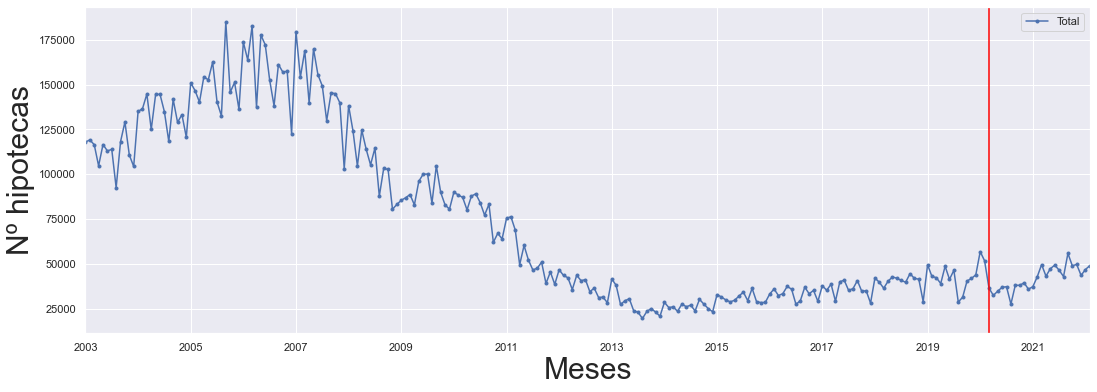

In [59]:
sns.set(rc={'figure.figsize':(18, 6)})
fig = df_hipotecas.plot(marker='.') 
fig.set_ylabel('Nº hipotecas', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Meses', fontsize = 30);

<font color='red'>ANALIZARLO</font>

A continuación, analizaremos la estacionalidad mediante:
- Cálculo de la media y de la varianza
- Gráficas de comportamiento mensual
- Desglose de la tendencia, de la estacionalidad y residuos

In [60]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

In [63]:
media = split_and_summarize(df_hipotecas, 'Total', 4, np.mean)

varianza = split_and_summarize(df_hipotecas, 'Total', 4, np.var)

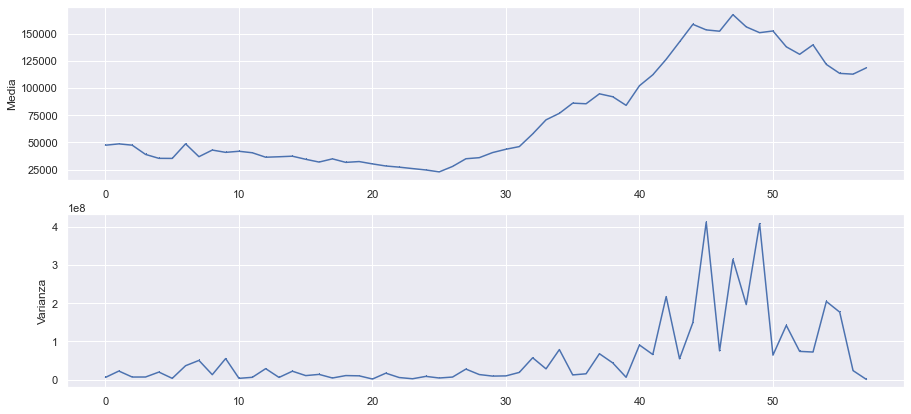

In [64]:
cols = ['media', 'varianza']
df = pd.DataFrame([media, varianza], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(media, ',-')
ax1.set_ylabel('Media')

ax2.plot(varianza, ',-')
ax2.set_ylabel('Varianza')

plt.show()

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

<font color='red'>CORREGIR ESTO</font>

ValueError: Expected frequency -1MS. Got M

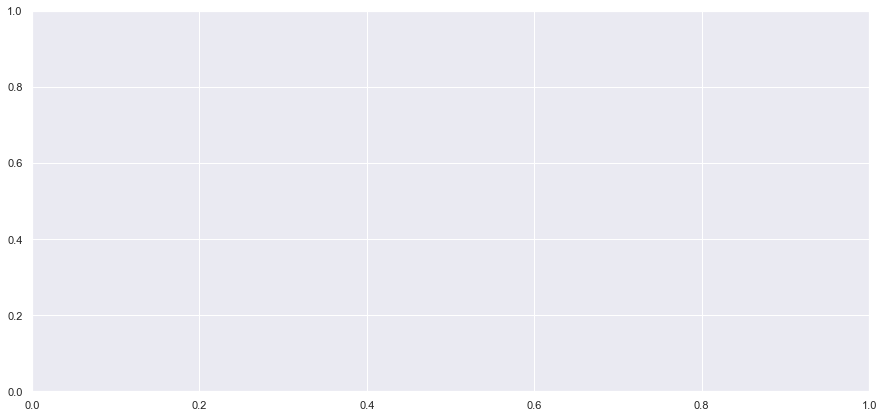

In [67]:
# Componente estacional mensual:
ax = plt.gca() 
sm.graphics.tsa.month_plot(df_hipotecas['Total'], ax = ax)
ax.set_title('Comportamiento mensual', fontsize = 30);

Pasamos a realizar un boxplot mensual para estudiar las distribuciones:

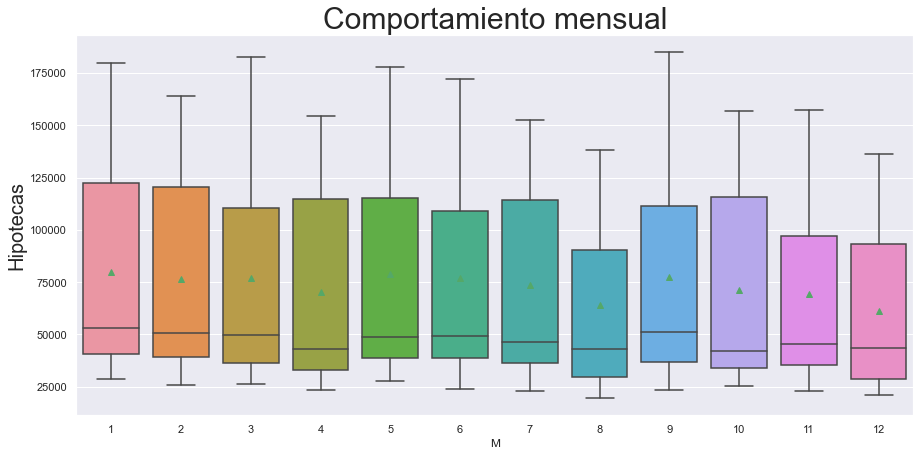

In [70]:
df_hipotecas['M'] = df_hipotecas.index.month
sns.boxplot(data = df_hipotecas, x = 'M', y='Total', showmeans=True)
ax = plt.gca()
ax.set_ylabel('Hipotecas', fontsize = 20)
ax.set_title('Comportamiento mensual', fontsize = 30);

Y, por último, el desglose de la estacionalidad, tendencia y residuos:

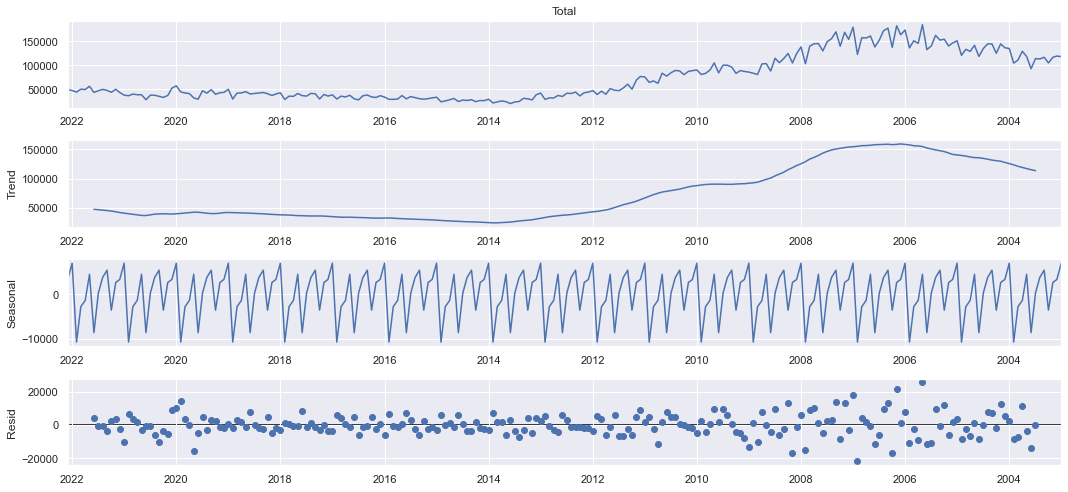

In [72]:
desglose = seasonal_decompose(df_hipotecas['Total'], 
                                   model='additive', 
                                   period=12);
desglose.plot();

Analizando las gráficas, observamos:

<font color='red'>ANALIZARLO</font>